<a href="https://colab.research.google.com/github/JohanEstebanCuervo/Comunicaciones_Digitales/blob/main/Phase_Shift_Keying_(PSK).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias a utilizar

In [528]:
!pip install scikit-commpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [529]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg 
from math import ceil
from commpy.modulation import QAMModem
from commpy.filters import rrcosfilter
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

In [530]:
def Grafica_PSD(signal,Fs,title='Espectro de Potencia'):
  f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)
  f = np.concatenate((np.flip(-f),f))
  Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

  plt.figure(figsize=(16,9))
  plt.plot(f, 10*np.log10(Pxx_den))
  plt.xlabel('frequency [Hz]',fontsize = 14)
  plt.ylabel('PSD [dB/Hz]',fontsize = 14)
  plt.title(title,fontsize = 20)
  plt.grid()
  plt.show()

def eyediagram(signal,muestras_simbolo,title='Diagrama de ojo'):

  inicio=muestras_simbolo//2+1

  plt.figure(figsize=(16,9))
  plt.title(title,fontsize = 20)
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()

  signal=np.reshape(signal[inicio:len(signal)-muestras_simbolo+inicio],(-1,muestras_simbolo)).T
  x= np.arange(inicio-muestras_simbolo,inicio).T
  
  plt.plot(x,signal)

def Grafica_PSD_eyediagram(signal,Fs,muestras_simbolo,title='Señal'):
  f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)
  f = np.concatenate((np.flip(-f),f))
  Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

  fig= plt.figure(figsize=(25,6))
  plt.subplot(1,2,1)
  plt.plot(f, 10*np.log10(Pxx_den))
  plt.xlabel('frequency [Hz]',fontsize = 14)
  plt.ylabel('PSD [dB/Hz]',fontsize = 14)
  plt.title('Espectro de Potencia '+ title,fontsize = 20)
  plt.grid()

  plt.subplot(1,2,2)
  inicio=muestras_simbolo//2+1
  plt.title('Diagrama de ojo ' + title,fontsize = 20)
  plt.xlabel('Muestras',fontsize = 14)
  plt.ylabel('Amplitud',fontsize = 14)
  plt.grid()
  signal = np.reshape(signal[inicio:len(signal)-muestras_simbolo+inicio],(-1,muestras_simbolo)).T
  x= np.arange(inicio-muestras_simbolo,inicio).T
  
  plt.plot(x,signal)

  plt.show

def upsample(signal,N):

  y = np.zeros(len(signal)*N)

  for i in range(len(signal)):

    y[i*N] = signal[i]

  return y


def codificacion_PSK(X,orden,table=None):

  if table is None:

    table = np.arange(orden)

  cod= np.zeros((orden,2))
  salto_rad=2*np.pi/orden
  ang=0

  if orden == 4:
    ang=np.pi/4
  
  for i in range(orden):
    cod[i,0]=np.cos(ang)
    cod[i,1]=np.sin(ang)
    ang+=salto_rad


  code_PSK = np.zeros((len(X),2))

  for i in range(len(X)):
    code_PSK[i] = cod[table[X[i]]] 

  return code_PSK


def Decode_PSK(signal,Fp,Fs,Tb): ##  Fp -> Frecuencia Portadora. Fs -> Frecuencia de muestreo. Tb -> Tiempo de Baudio
                                  ##  Fs*Tb debe ser un numero entero  primera restricción

    t = np.linspace(0, len(signal)/Fs,len(signal))
    Portadorai = np.cos(2*np.pi*Fp*t)
    Portadoraq = np.cos(2*np.pi*Fp*t+np.pi/2)
    
    Y1 = signal*Portadorai
    Y2 = signal*Portadoraq
    
    decobits1 = np.mean(np.reshape(Y1, (-1,int(Fs*Tb))),axis=1)*2
    decobits2 = np.mean(np.reshape(Y2, (-1,int(Fs*Tb))),axis=1)*-2
    
    return np.reshape(np.concatenate((decobits1,decobits2)),(2,-1)).T

def Pulse_shaping_square(bits,muestras_simbolo):
    ps = np.ones(muestras_simbolo)
    bits_sample = upsample(bits, muestras_simbolo)

    return np.convolve(bits_sample,ps)[:-(muestras_simbolo-1)]

def Pulse_shaping_RRC(bits,muestras_simbolo,alpha=0,Amp_fil=4,Ts=1):
    longitud_filtro_m = Amp_fil*muestras_simbolo  #Longitud del filtro en Muestras
    Fs = muestras_simbolo/Ts  #Frecuencia de muestreo
    RRC = rrcosfilter(longitud_filtro_m, alpha=alpha, Ts=Ts, Fs=Fs)

    bits_sample = upsample(bits, muestras_simbolo)

    inicial= int(Amp_fil/2*muestras_simbolo)
    final = -(inicial-1)

    return np.convolve(bits_sample,RRC[1])[inicial:final]


def Graficas_PSK(modulador):
  fig = plt.figure(figsize=(15,15))

  ################## Primer plot Bits ##########################################
  plt.subplot(6,1,1)
  markerline, stemlines, baseline =plt.stem(np.arange(1,len(modulador.bits)+1), modulador.bits, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('Bits',fontsize = 14)
  xmin, xmax, _, _ = plt.axis()
  plt.grid()


  #################  Simbolo i #########################################
  plt.subplot(6,1,2)
  t_si = np.linspace(modulador.bit_grup,modulador.bit_grup*len(modulador.simboli),len(modulador.simboli))
  markerline, stemlines, baseline =plt.stem(t_si, modulador.simboli, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('Simbolos i',fontsize = 14)
  plt.xlim([xmin, xmax])
  plt.grid()

  ####################### PAM i ######################################################
  plt.subplot(6,1,3)
  markerline, stemlines, baseline =plt.stem(modulador.t, modulador.PAMi, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('PAM i',fontsize = 14)
  plt.grid()

  ##################### Simbolo q ############################################
  plt.subplot(6,1,4)
  markerline, stemlines, baseline =plt.stem(t_si, modulador.simbolq, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('Simbolos q',fontsize = 14)
  plt.xlim([xmin, xmax])
  plt.grid()


  ####################### PAM q ######################################################

  plt.subplot(6,1,5)
  markerline, stemlines, baseline =plt.stem(modulador.t, modulador.PAMq, linefmt ='gray', markerfmt ='D')
  plt.setp(baseline, 'linewidth', 1,'color','blue')
  plt.setp(markerline, markersize=7)
  markerline.set_markerfacecolor('black') 
  markerline.set_markeredgecolor('black')
  plt.ylabel('PAM q',fontsize = 14)
  plt.grid()

  ####################### PAM q ######################################################

  plt.subplot(6,1,6)
  plt.plot(modulador.t, modulador.signal,color='gray')
  plt.ylabel('signal',fontsize = 14)
  plt.grid()
  

In [531]:
class PSK_Modulation:

  def __init__(self,freq_por,time_bit,simbol_sample):
    self.type_PAM= 'square'    # tipo de PAM 'RRC' O 'square'
    self.bit_grup=2            # Numero de bits agrupados
    self.order_mod= 2**self.bit_grup          
    self.freq_por=freq_por
    self.time_bit=time_bit
    self.simbol_sample=simbol_sample
    self.alpha=1
    self.span_RRC=4
    self.Ts=1
    self.time_simbol= time_bit*self.bit_grup
    self.table= np.arange(self.order_mod)
    self.Fs = self.simbol_sample/(self.time_bit*self.bit_grup)

  def charge_bits(self,bits):
    self.bits = bits
    self.decimal = self.bintodecimal(bits,self.bit_grup)
    code_PSK = self.codificacion_PSK(self.decimal)
    self.simboli = code_PSK[:,0]
    self.simbolq = code_PSK[:,1]

    if self.type_PAM == 'square':
      self.PAMi= Pulse_shaping_square(code_PSK[:,0],self.simbol_sample)
      self.PAMq= Pulse_shaping_square(code_PSK[:,1],self.simbol_sample)

    elif self.type_PAM == 'RRC':
      self.PAMi= Pulse_shaping_RRC(code_PSK[:,0],self.simbol_sample)
      self.PAMq= Pulse_shaping_RRC(code_PSK[:,1],self.simbol_sample)

    else:
      print('Type PAM equivocado o no implementado: ' + str(self.type_PAM)+'   !!!!!')

    self.t = np.linspace(0,self.time_simbol*len(self.simboli),len(self.PAMi))
    self.portadorai = np.cos(2*np.pi*self.freq_por*self.t)
    self.portadoraq = np.cos(2*np.pi*self.freq_por*self.t+np.pi/2)

    self.signal = self.PAMi*self.portadorai-self.PAMq*self.portadoraq
    
  def set_bitgrup(self,val):
    self.bit_grup=int(val)
    self.order_mod= 2**self.bit_grup
    self.time_simbol= self.time_bit*self.bit_grup
    self.table= np.arange(self.order_mod)
    self.Fs = self.simbol_sample/(self.time_bit*self.bit_grup)


  def upsample(self,signal,N):

    y = np.zeros(len(signal)*N)

    for i in range(len(signal)):

      y[i*N] = signal[i]

    return y

  def codificacion_PSK(self,X):

    self.cod= np.zeros((self.order_mod,2))
    salto_rad=2*np.pi/self.order_mod
    ang=0

    if self.order_mod == 4:
      ang=np.pi/4
    
    for i in range(self.order_mod):
      self.cod[i,0]=np.cos(ang)
      self.cod[i,1]=np.sin(ang)
      ang+=salto_rad


    code_PSK = np.zeros((len(X),2))

    for i in range(len(X)):
      code_PSK[i] = self.cod[self.table[X[i]]] 

    return code_PSK

  def Pulse_shaping_square(self,bits,muestras_simbolo):
    ps = np.ones(muestras_simbolo)
    bits_sample = upsample(bits, muestras_simbolo)

    return np.convolve(bits_sample,ps)[:-(muestras_simbolo-1)]


  def Pulse_shaping_RRC(self,bits,muestras_simbolo):
    longitud_filtro_m = self.span_RRC*muestras_simbolo  #Longitud del filtro en Muestras
    Fs = muestras_simbolo/self.Ts  #Frecuencia de muestreo
    RRC = rrcosfilter(longitud_filtro_m, alpha=self.alpha, Ts=self.Ts, Fs=Fs)

    bits_sample = upsample(bits, muestras_simbolo)

    inicial= int(self.span_RRC/2*muestras_simbolo)
    final = -(inicial-1)

    return np.convolve(bits_sample,RRC[1])[inicial:final]

  def bintodecimal(self,X,n,relleno='antes'):
    tam= np.shape(X)[0]
    if tam%n!=0:

      if relleno =='antes':
        X = np.concatenate((np.zeros(n-tam%n),X)).astype(int)

      if relleno =='despues':
        X = np.concatenate((X,np.zeros(n-tam%n))).astype(int)

    X = np.reshape(X,(-1,n))*2
    res = np.copy(X[:,-1])//2
    X = np.power(X,np.flip(np.arange(n)))

    X[:,-1]=X[:,-1]*res

    X = np.sum(X,axis=1).astype(int)

    return X

  def Decode_PSK(self,signal): ##  Fp -> Frecuencia Portadora. Fs -> Frecuencia de muestreo. Tb -> Tiempo de Baudio
                                  ##  Fs*Tb debe ser un numero entero  primera restricción
    #signal= signal.reshape((-1,self.simbol_sample))
    #print(np.shape(signal))
    t = np.linspace(0, len(signal)/self.Fs,len(signal))
    Portadorai = np.cos(2*np.pi*self.freq_por*t)
    Portadoraq = np.cos(2*np.pi*self.freq_por*t+np.pi/2)
    Muestras_ciclo = self.simbol_sample/(self.freq_por*self.time_simbol)
    xsig = (signal*Portadorai).reshape((-1,self.simbol_sample))
    ysig = (signal*Portadoraq).reshape((-1,self.simbol_sample))

    x = np.mean(xsig[:,:round(Muestras_ciclo)],axis=1).reshape((-1,1))*2
    y = np.mean(ysig[:,:round(Muestras_ciclo)],axis=1).reshape((-1,1))*2
    #print(len(x))
    #decobits1 = np.mean(np.reshape(x, (-1,int(self.Fs*self.time_simbol))),axis=1)*2
    #decobits2 = np.mean(np.reshape(y, (-1,int(self.Fs*self.time_simbol))),axis=1)*-2
    
    return np.concatenate((x,-y),axis=1)#np.reshape(np.concatenate((decobits1,decobits2)),(2,-1)).T

  def Estimation_Bits(self,Points):

    point_est = self.Point_est(Points)
    decimal = np.where(self.table==point_est.reshape((-1,1)))[1]

    return self.decimaltobin(decimal).astype('int')


  def Point_est(self,Points):

    dist = np.zeros((len(Points),self.order_mod))

    for i in range(self.order_mod):

      dist[:,i]= np.sum(np.power(Points-self.cod[i],2),axis=1)


    return np.argmin(dist,axis=1)
  
  def decimaltobin(self,decimal):

    bits=np.array([0])

    for num in decimal:

      bin = np.array(list(str("{0:b}".format(num)))).astype('int')
      if(len(bin)!=self.bit_grup):
        bin = np.concatenate((np.zeros(self.bit_grup-len(bin)),bin))

      bits= np.concatenate((bits,bin))

    return bits[1:]





# Modulación PSK

**Baudio:** Cantidad de Simbolos por segundo que se envian en una comunicación. Un simbolo es la representación de un grupo de bits
 
**Modulador en Cuadratura:** Tecnica de Modulación la cual consiste en dos señales PAM, multiplicadas por dos señales portadoras ortogonales. Lo cual en la practica significa dos señales senoidales con la misma
frecuencia desfasadas 90 grados.
 
**Proceso de Mapeo:**  Es la designación del valor de cada grupo bits en el diagrama de constelación.

**Ruido aditivo blanco Gaussiano:** Distorción generada en una señal transmitida la cual tiene la caracteristica que tienen componentes en todas las frecuencias al igual magnitud

Se implementaron codigos realizados para poder hacer maping y poder formar señales PSK de cualquier orden BPSK,QPSK,8PSK, ETC.. 

La explicación para el uso de las funciones creadas es la siguiente:

**MAPEO:** Para mapear cualquier tren de bits a gusto se debe poner en la opción table un vector en el cual la posición del array indica el numero en decimal del grupo de bits y el valor entero indica el numero de punto en la asignación. Los puntos inician contando en contra de las manecillas del reloj en la posición (1,0), excepto para QPSK que inicia en (0.7,0.7) Ejemplo:


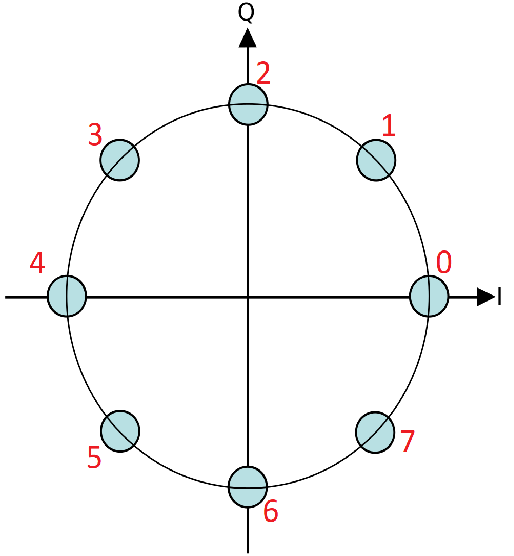

Si en table se envia: [7,1,2,3,4,5,6,0]

la codificacion seria:

      Point    Bin 
      7        000
      1        001
      2        010
      3        011
      :::
      0        111





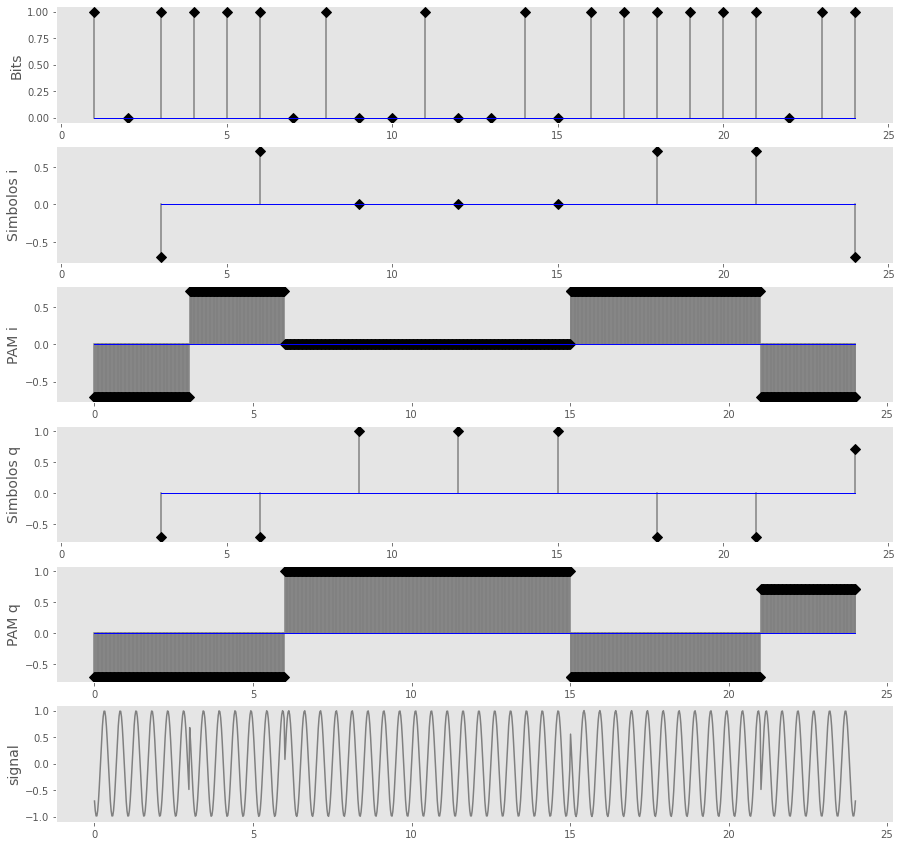

In [532]:
simbol_sample= 120
time_bit = 1 # tiempo de bit
freq_por = 2

bit_grup=3  # numero de bits agrupados
modulador = PSK_Modulation(freq_por, time_bit, simbol_sample)
modulador.set_bitgrup(bit_grup)
#modulador.table=np.array([3,1,2,0])
Nbits = 8*bit_grup #numero de bits
bits = np.random.randint(0,2,Nbits) #señal de bits
modulador.charge_bits(bits)


Graficas_PSK(modulador)



**NOTA** Tener cuidado al plotear una señal BPSK ya que visualmente parece que la portadora Q tiene valores. Pero en realidad son valores muy pequeños causados por el error al calcular computacionalmente el coseno. Se puede observa que el eje y llega a 1e-16 lo cual es practicamente 0.

Como se puede ver la señal PSK siempre tiene la misma amplitud y solo se ve afectada la fase cuando se utilizan PAM con forma cuadrada. Ahora se analizara el caso en el que se utilizan PAM con pulse shaping RRC

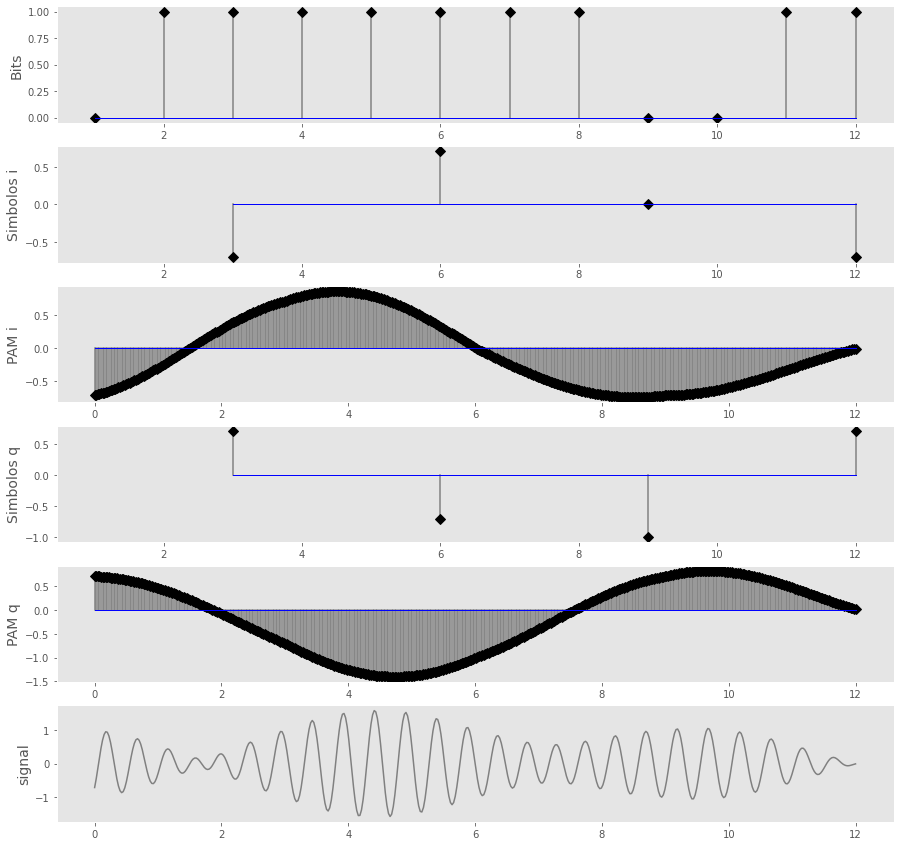

In [533]:
simbol_sample= 120
time_bit = 1 # tiempo de bit
freq_por = 2
bit_grup= 3  # numero de bits agrupados
modulador = PSK_Modulation(freq_por, time_bit, simbol_sample)
modulador.set_bitgrup(bit_grup)
modulador.alpha=0
modulador.type_PAM='RRC'

Nbits = 4*bit_grup #numero de bits
bits = np.random.randint(0,2,Nbits) #señal de bits

modulador.charge_bits(bits)

Graficas_PSK(modulador)


Al utilizar PAM con pulse shaping RRC y alpha=0. Ademas de existir una modulacion en fase tambien existe una modulación en amplitud. Adicionalmente no se obserban los cambios bruscos de fase. Por lo cual el espectro se va a notar claramente afectado por el tipo de PAM que se utiliza. 

# Espectros

Frecuencia minima de muestreo: 8000000.0
Frecuencia de muestreo: 20000000.0


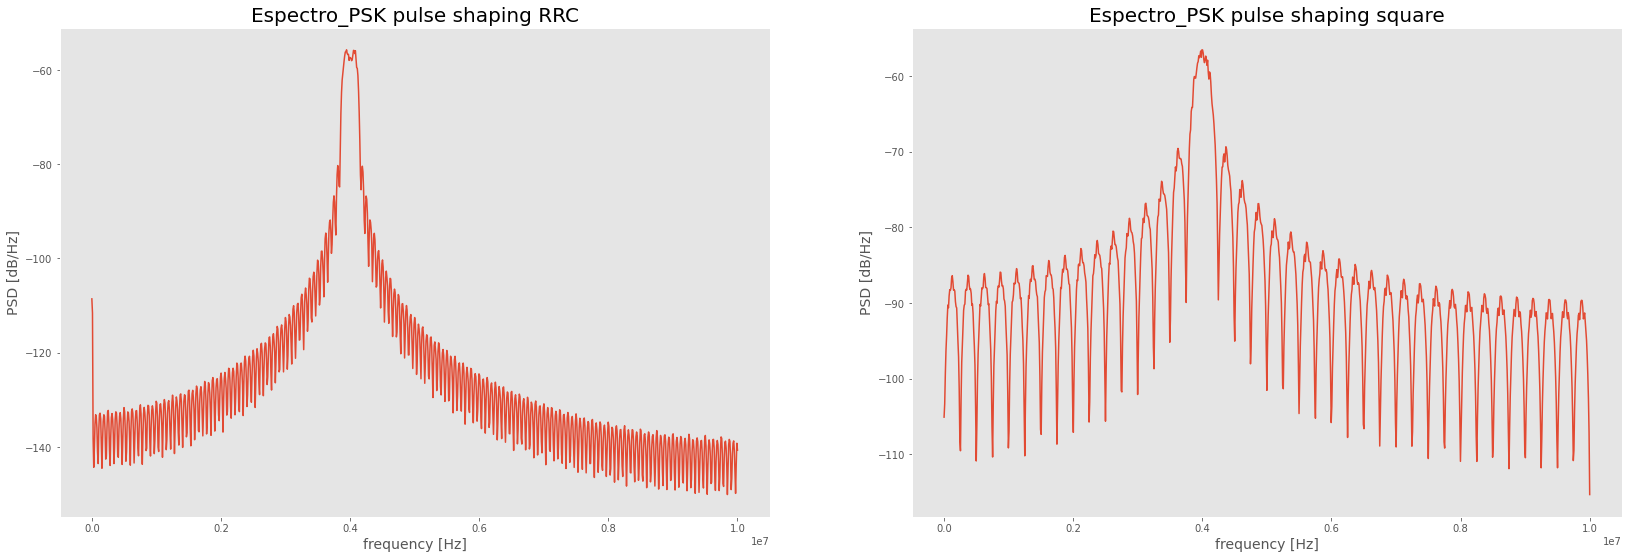

In [534]:
simbol_sample= 80
time_bit = 1e-6 # tiempo de bit
freq_por = 4e6
bit_grup= 4  # numero de bits agrupados

Fs_min = 2*freq_por
print("Frecuencia minima de muestreo: " + str(Fs_min))  # Tener en cuenta ya que de ser muy baja las transformadas de fourier no seran correctas
modulador_RRC = PSK_Modulation(freq_por, time_bit, simbol_sample)
modulador_RRC.set_bitgrup(bit_grup)
modulador_RRC.alpha=0
modulador_RRC.type_PAM='RRC'


modulador_square = PSK_Modulation(freq_por, time_bit, simbol_sample)
modulador_square.set_bitgrup(bit_grup)

Nbits = 4000 #numero de bits
bits = np.random.randint(0,2,Nbits) #señal de bits

modulador_RRC.charge_bits(bits)
modulador_square.charge_bits(bits)

Fs= simbol_sample/(time_bit*bit_grup)
print("Frecuencia de muestreo: " + str(Fs))
f, Pxx_den = sg.welch(modulador_RRC.signal, Fs,nperseg=2048, nfft=2048)
f = np.concatenate((np.flip(-f),f))
Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

plt.figure(figsize=(28,9))

plt.subplot(1,2,1)
plt.plot(f[len(f)//2:], 10*np.log10(Pxx_den[len(f)//2:]))
plt.xlabel('frequency [Hz]',fontsize = 14)
plt.ylabel('PSD [dB/Hz]',fontsize = 14)
plt.title('Espectro_PSK pulse shaping RRC',fontsize = 20)
plt.grid()

f, Pxx_den = sg.welch(modulador_square.signal, Fs,nperseg=2048, nfft=2048)
f = np.concatenate((np.flip(-f),f))
Pxx_den = np.concatenate((np.flip(Pxx_den),Pxx_den))

plt.subplot(1,2,2)
plt.plot(f[len(f)//2:], 10*np.log10(Pxx_den[len(f)//2:]))
plt.xlabel('frequency [Hz]',fontsize = 14)
plt.ylabel('PSD [dB/Hz]',fontsize = 14)
plt.title('Espectro_PSK pulse shaping square',fontsize = 20)
plt.grid()


Como se puede ver el ancho del espectro con el RRC es mitad de ancho que con el pulse shaping cuadrado. Esto trae beneficios en el espectro aunque dificulta la parte de la demodulación

#Demodulación

Se hace necesario realizar un demodulador para poder hacer un analisis del impacto del SNR en la señal. Y ademas poder obtener los diagramas de constelación.

El primer demodulador que podemos pensar es para un pulse shaping cuadrado y utilizando el producto punto podriamos obtener el punto en el plano de la siguiente manera:

$I$:  portadora I

$Q$:  portadora Q

$x$,$y$ <- Posicion en el plano


Signal= $x*I$ - $y*Q$

si: $\cdot$ se define como el producto punto entre las dos señales se sabe que 

$I$ $\cdot$ $Q$ = $0$

Entonces:

Signal $\cdot$ $I$ = $x$*$I^2$

Signal $\cdot$ $Q$ = $y$*$Q^2$

Como se sabe las portadoras son señales cosenoidales de amplitud 1 por lo tanto si promediamos las primeras muestras de cada simbolo y luego multiplicamos por 2 se obtendria una buena estimación de la fase de dicha señal. Que tantas muestras tomemos para promediar va a volver mas fuerte o debil nuestro demodulador frente al ruido cuando se tiene un Pulse Shaping cuadrado. Ya que en un RRC tiene que sacarse el promedio en las primeras muestras.

La implementación esta en el codigo del objeto codificación PSK.




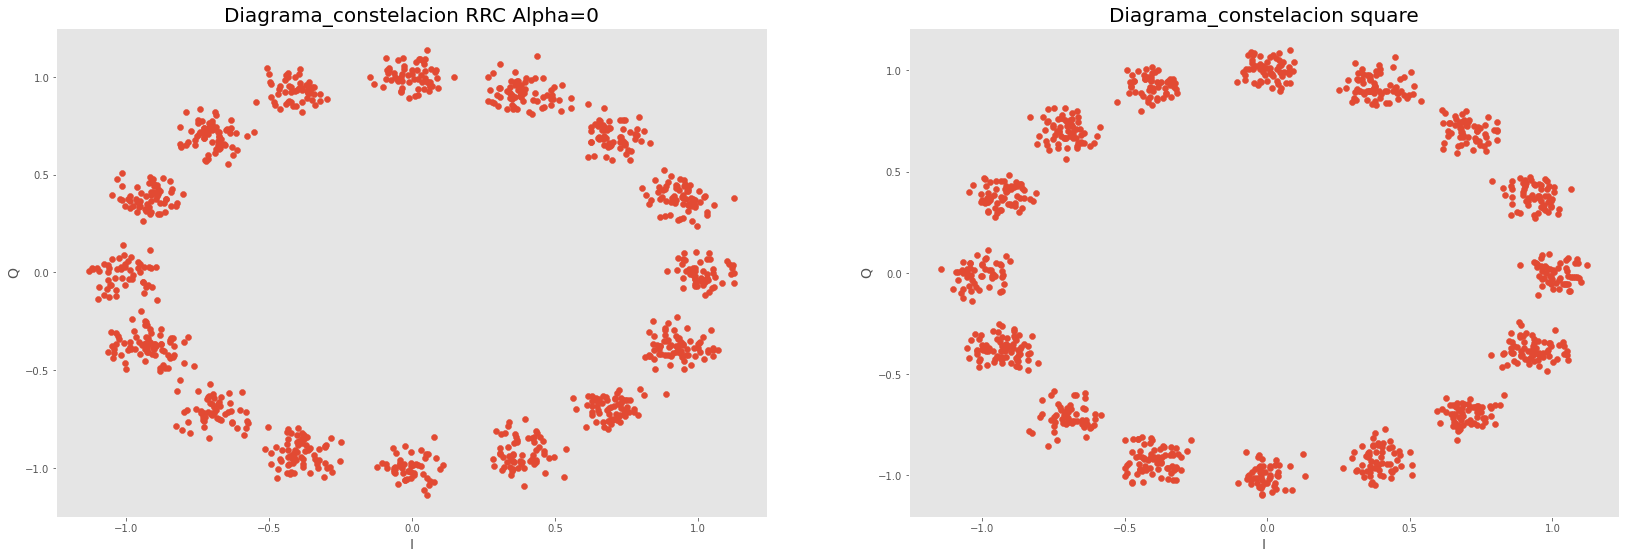

In [535]:
n=0.3
noise= n*np.random.random(len(modulador_square.signal))-n/2
Diagrama_cons_RRC = modulador_RRC.Decode_PSK(modulador_RRC.signal+noise)
Diagrama_cons_square = modulador_square.Decode_PSK(modulador_square.signal+noise)



plt.figure(figsize=(28,9))

plt.subplot(1,2,1)
plt.scatter(Diagrama_cons_RRC[:,0],Diagrama_cons_RRC[:,1])
plt.xlabel('I',fontsize = 14)
plt.ylabel('Q',fontsize = 14)
plt.title('Diagrama_constelacion RRC Alpha=0',fontsize = 20)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(Diagrama_cons_square[:,0],Diagrama_cons_square[:,1])
plt.xlabel('I',fontsize = 14)
plt.ylabel('Q',fontsize = 14)
plt.title('Diagrama_constelacion square',fontsize = 20)
plt.grid()

Nuestro demodulador esta funcionando bien. Logra distinguir entre los puntos, Pero tiene algunas falencias para el pulse shaping RRC ya que se ven estos puntos dispersos sin sumarle ruido a la señal por lo tanto con este Pulse shaping va a ser más sensible al ruido que con la forma de pulso cuadrada. 

#SNR vs Errores de bits

Calculo del SNR. El SNR sera calculado con base al espectro de potencia de la señal.
Ejemplo:

Frecuencia de muestreo: 20000000.0


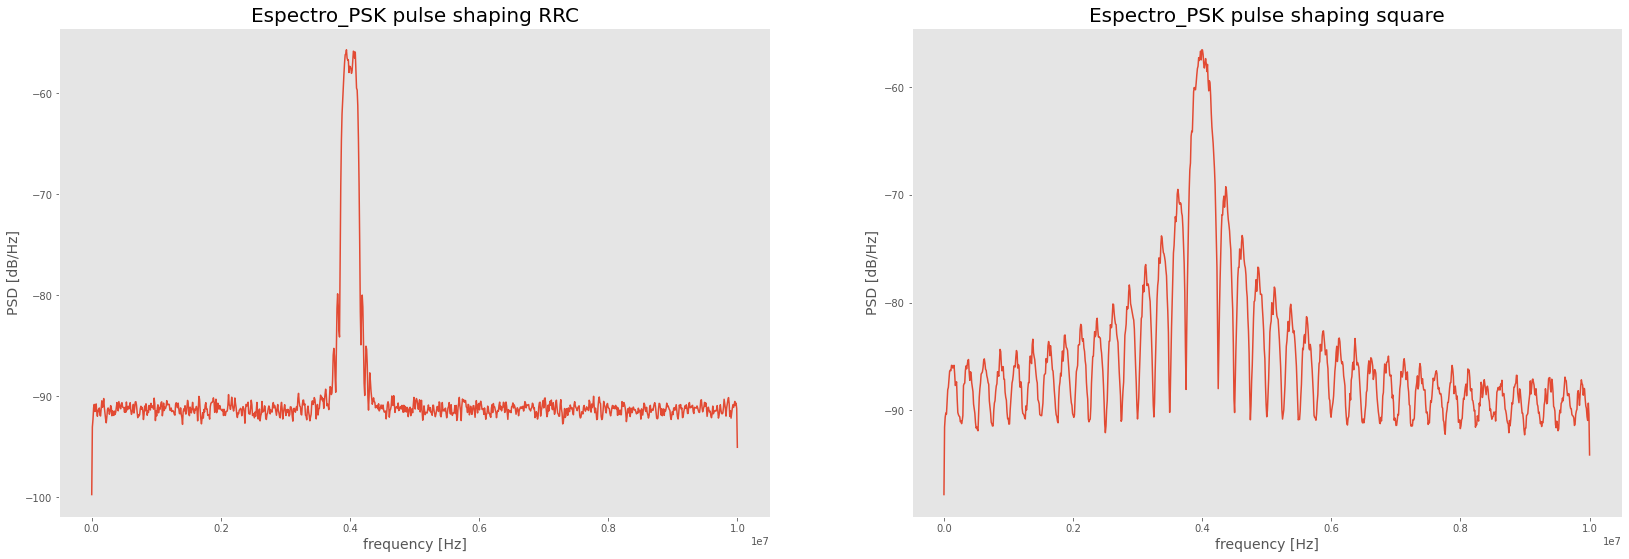

In [536]:
N_r = .3
Fs= simbol_sample/(time_bit*bit_grup)
print("Frecuencia de muestreo: " + str(Fs))
signal= modulador_RRC.signal + N_r*np.random.random(len(modulador_RRC.signal))-N_r/2
f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)

plt.figure(figsize=(28,9))

plt.subplot(1,2,1)
plt.plot(f, 10*np.log10(Pxx_den))
plt.xlabel('frequency [Hz]',fontsize = 14)
plt.ylabel('PSD [dB/Hz]',fontsize = 14)
plt.title('Espectro_PSK pulse shaping RRC',fontsize = 20)
plt.grid()

signal= modulador_square.signal + N_r*np.random.random(len(modulador_square.signal))-N_r/2
f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)

plt.subplot(1,2,2)
plt.plot(f, 10*np.log10(Pxx_den))
plt.xlabel('frequency [Hz]',fontsize = 14)
plt.ylabel('PSD [dB/Hz]',fontsize = 14)
plt.title('Espectro_PSK pulse shaping square',fontsize = 20)
plt.grid()

Tomamos el maximo del espectro de potencia y la media de una parte de la base. Esto se puede ver mas facil en el especto de RRC ya que su espectro tiene las componente de frecuencia concentradas.

In [537]:
Espectro = 10*np.log10(Pxx_den)
P_s = np.max(Espectro)
P_ruido = np.mean(Espectro[np.where(f>2*modulador_RRC.freq_por)])
SNR= P_s-P_ruido

print('El SNR para la amplitud de ruido seria de: ' + str(SNR)+'db')

El SNR para la amplitud de ruido seria de: 32.691279911418015db


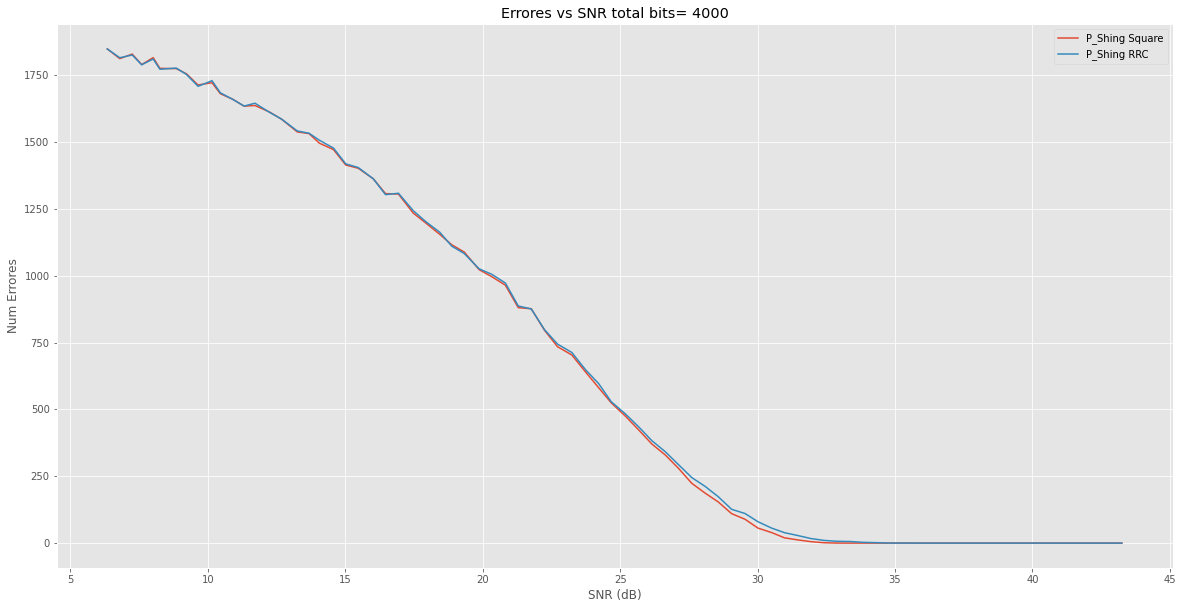

In [538]:
muestras=80
table = np.zeros((muestras,3))

for i,amp_r in enumerate(np.logspace(-1,1,muestras)):
  errores_square=0
  errores_RRC=0
  SNR=0
  
  for k in range(10):
    #Calculo del diagrma de constelacion o de los puntos en el plano
    noise= amp_r*np.random.random(len(modulador_square.signal))-amp_r/2
    Diagrama_cons_square = modulador_square.Decode_PSK(modulador_square.signal+noise)
    Diagrama_cons_RRC = modulador_RRC.Decode_PSK(modulador_RRC.signal+noise)

    #calculo de los bits estimados
    bits_est_square = modulador_square.Estimation_Bits(Diagrama_cons_square)
    bits_est_RRC = modulador_RRC.Estimation_Bits(Diagrama_cons_RRC)
    
    #Errores en la estimacion
    errores_square += np.sum(np.abs(bits_est_square-bits))
    errores_RRC += np.sum(np.abs(bits_est_RRC-bits))

    #Calculo del SNR apartir del espectro de potencia
    signal= modulador_RRC.signal + noise
    f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)

    Espectro = 10*np.log10(Pxx_den)
    P_s = np.max(Espectro)
    P_ruido = np.mean(Espectro[np.where(f>2*modulador_RRC.freq_por)[:-100]])
    SNR+= P_s-P_ruido

  table[i]= [SNR/10,errores_square/10,errores_RRC/10]

plt.style.use('ggplot')  
plt.figure(figsize=(20,10)) 
plt.plot(table[:,0],table[:,1],label='P_Shing Square')
plt.plot(table[:,0],table[:,2],label='P_Shing RRC')

plt.xlabel('SNR (dB)')                       #eje x
plt.ylabel('Num Errores')                            #eje y
plt.title('Errores vs SNR total bits= 4000')              #título
plt.legend()                               #mostrar referencias
plt.savefig("erroresvsSNR.png")               #guardar el gráfico en una imagen .png

Con base en esta grafica el SNR estimado que todavia permie diferenciar los puntos seria de aproximadamente 32dB. 

Como dato mas interesante es la comparación de las dos graficas de la forma de pulso. En un momento sospeche que con el P_shaping RRC los errores serian mayores comparado con la forma de pulso cuadrada pero no es asi. Por lo menos para el tipo de demodulador implementado.

Frecuencia de muestreo: 20000000.0


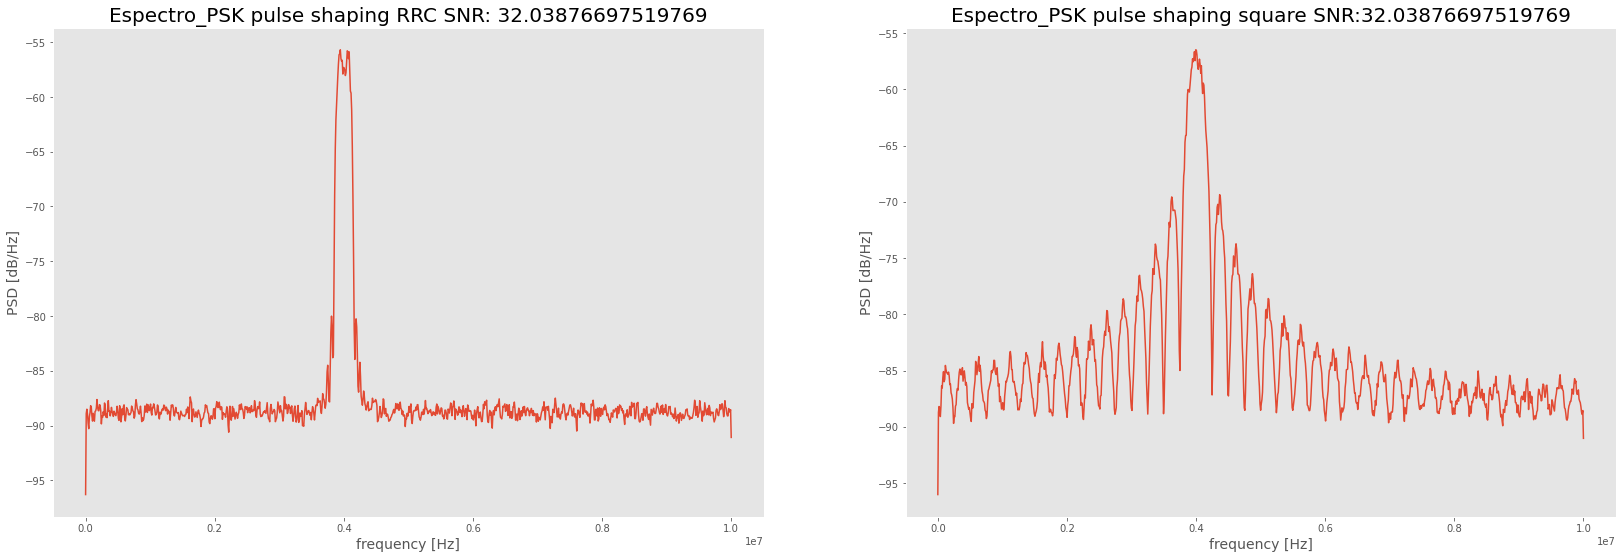

In [539]:
N_r = 0.4
Fs= simbol_sample/(time_bit*bit_grup)
Noise= N_r*np.random.random(len(modulador_RRC.signal))-N_r/2
print("Frecuencia de muestreo: " + str(Fs))
signal= modulador_RRC.signal + Noise
f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)

Espectro = 10*np.log10(Pxx_den)
P_s = np.max(Espectro)
P_ruido = np.mean(Espectro[np.where(f>2*modulador_RRC.freq_por)[:-100]])
SNR= P_s-P_ruido

plt.figure(figsize=(28,9))

plt.subplot(1,2,1)
plt.plot(f, 10*np.log10(Pxx_den))
plt.xlabel('frequency [Hz]',fontsize = 14)
plt.ylabel('PSD [dB/Hz]',fontsize = 14)
plt.title('Espectro_PSK pulse shaping RRC SNR: ' + str(SNR),fontsize = 20)
plt.grid()

signal= modulador_square.signal + Noise
f, Pxx_den = sg.welch(signal, Fs,nperseg=2048, nfft=2048)

plt.subplot(1,2,2)
plt.plot(f, 10*np.log10(Pxx_den))
plt.xlabel('frequency [Hz]',fontsize = 14)
plt.ylabel('PSD [dB/Hz]',fontsize = 14)
plt.title('Espectro_PSK pulse shaping square SNR:'+ str(SNR) ,fontsize = 20)
plt.grid()

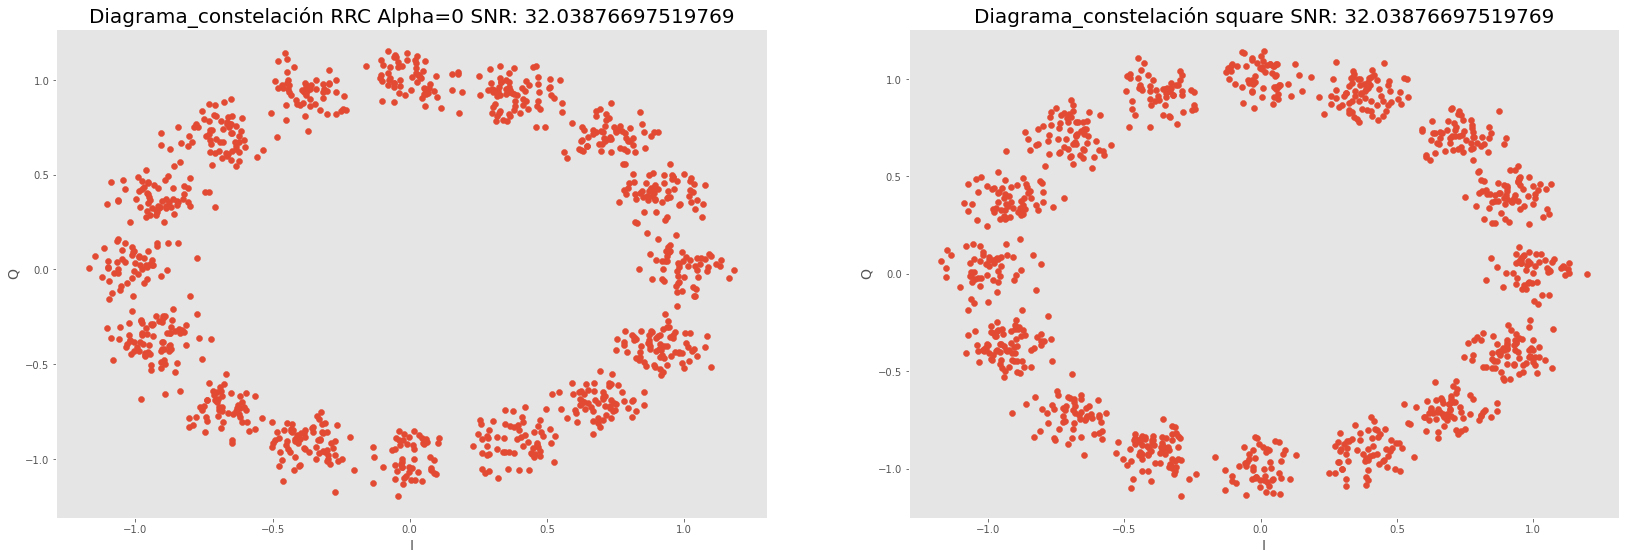

In [540]:
Diagrama_cons_RRC = modulador_RRC.Decode_PSK(modulador_RRC.signal+Noise)
Diagrama_cons_square = modulador_square.Decode_PSK(modulador_square.signal+Noise)

plt.figure(figsize=(28,9))

plt.subplot(1,2,1)
plt.scatter(Diagrama_cons_RRC[:,0],Diagrama_cons_RRC[:,1])
plt.xlabel('I',fontsize = 14)
plt.ylabel('Q',fontsize = 14)
plt.title('Diagrama_constelación RRC Alpha=0 SNR: '+ str(SNR),fontsize = 20)
plt.grid()

plt.subplot(1,2,2)
plt.scatter(Diagrama_cons_square[:,0],Diagrama_cons_square[:,1])
plt.xlabel('I',fontsize = 14)
plt.ylabel('Q',fontsize = 14)
plt.title('Diagrama_constelación square SNR: '+ str(SNR),fontsize = 20)
plt.grid()

Como se puede Observar un SNR de 32dB esta justo en el limite para diferenciar los simbolos de cada señal.

Hay que tener en cuenta que este valor es sin aplicar ningun filtro a la señal. Ya que implementado un filtro pasa banda para la señal. Muy probablemte la decodificación sera mas fuerte al ruido